In [1]:
import numpy as np
import cvxpy as cp

import scipy

from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Iterative Soft Thresholding Algorithm (ISTA)

In [2]:
def softshrink(x, lambda_):
    return np.sign(x) * np.maximum(0, np.abs(x) - lambda_)

In [3]:
def ISTA(y, A, L, eps = 1e-4, max_iter = 3000):

    x = np.random.randn(A.shape[1])

    loss = np.linalg.norm(y - A @ x)**2 + L * np.linalg.norm(x, ord = 1)
    losses = [loss]
    iters = 0

    B = A.T @ y
    C = A.T @ A

    mu = np.real(1 /np.max(np.linalg.eigvals(C)))
    
    while loss > eps and iters < max_iter:

        x_hat = x - mu*(C @ x - B) 
        x = softshrink(x_hat, L * mu)

        # Decreasing step size
        #mu *= 0.99

        # Loss tracking
        loss = np.linalg.norm(y - A @ x)**2 + L * np.linalg.norm(x, ord = 1)
        losses.append(loss)

        iters += 1
        
    return x, losses

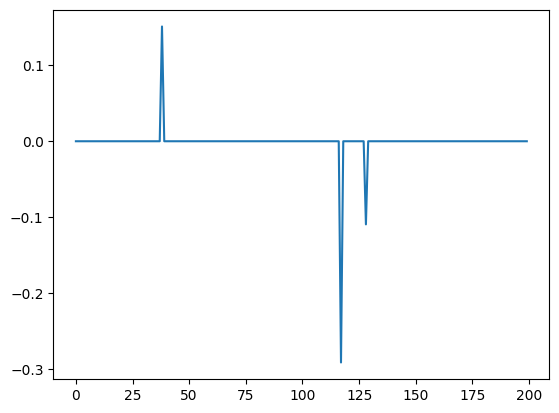

In [4]:
S = np.zeros(200)
S[np.random.choice(200, 3)] = np.random.normal(scale=0.5, size = 3)
plt.plot(S)

In [5]:
A = np.random.normal(size = (150,200))
A /= np.linalg.norm(A, axis = 0)

In [6]:
y = A @ S

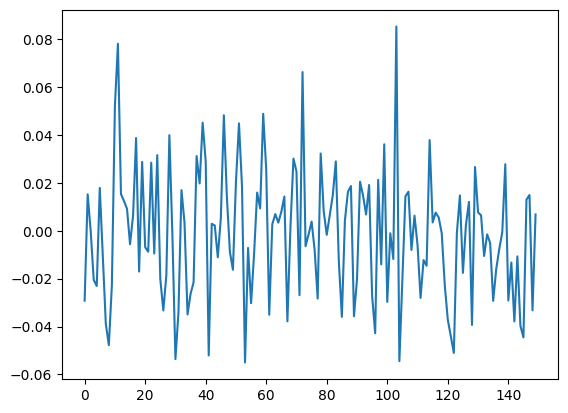

In [7]:
plt.plot(y)

In [8]:
x, losses = ISTA(y, A, 1e-1)

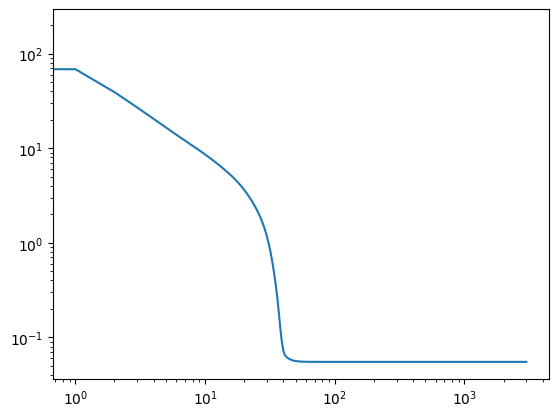

In [9]:
plt.loglog(losses)

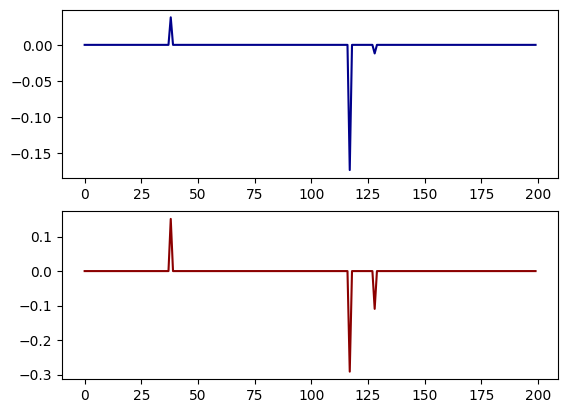

In [10]:
fig, axs = plt.subplots(2)

axs[0].plot(x, color='darkblue')
axs[1].plot(S, color='darkred')

plt.show()

# Learned Iterative Soft Thresholding Algorithm (LISTA)

In [42]:
class SyntheticSignals():
    def __init__(self, A, n, m, p=0.1, SNR=None, size=1000, batch_size=512):
        
        # Model complexity
        self.n = n  # Number of samples in the original signal
        self.m = m  # Number of samples through the linear transformation

        # Sensing matrix
        if A is None:                            
            self.A = self.A_initialization()          
        else:
            self.A = A

        # Sparsity and noise
        self.p = p  # Sparsity of the signal in terms of percentage of components being non-zero
        self.SNR = SNR  # Signal-to-noise ratio 

        # Size and batch size
        self.batch_size = batch_size
        self.size = size  # Size of the dataset

        # Preallocation
        self.x = torch.zeros(self.size, self.n)
        self.y = torch.zeros(self.size, self.m)
        
        # Generating the dataset
        self.set_data()

    def A_initialization(self):
        A = torch.normal(0, torch.sqrt(torch.tensor(1/self.m)), size=(self.m, self.n))
        A /= torch.linalg.norm(A, dim=0)  # Normalize columns
        return A
    
    def set_tuple(self, i):
        # Reset the signal to zero before generating a new sparse signal
        self.x[i, :] = 0

        # Generating random sparsity in the canonical basis of the original signal
        idxs = np.random.choice(self.n, int(self.p * self.n), replace=False)
        peaks = np.random.normal(kloc = 0, scale=1, size=int(self.p * self.n))

        # Generating the original signal and its corrupted observations
        self.x[i, idxs] = torch.from_numpy(peaks).to(self.x)
        self.y[i, :] = self.A @ self.x[i, :] 
        
        # Adding noise based on the SNR if provided
        if self.SNR is not None:
            var = torch.mean(self.y[i, :]**2) / self.SNR
            self.y[i, :] += torch.normal(mean=0, std=torch.sqrt(var), size=(self.m,))

    def set_data(self):
        for i in range(self.size):
            self.set_tuple(i)
    
    def set_loader(self):
        return Data.DataLoader(dataset=Data.TensorDataset(self.y, self.x),
                               batch_size=self.batch_size,
                               shuffle=True)


In [58]:
# Dimensions for the signal, its sparsity and its observation

n_ = 500
m_ = 250
p_ = 0.1

# Sensing matrix

A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
A_ /= torch.linalg.norm(A_, dim = 0)

# Building a training set and a test set 
train_set = SyntheticSignals(
    A = A_,
    n = n_,        
    m = m_,
    p = p_,
    SNR = None,
    size = 4000
    ).set_loader()

test_set = SyntheticSignals(
    A = A_,
    n = n_,        
    m = m_,
    p = p_,
    SNR = None,
    size = 1000
    ).set_loader()

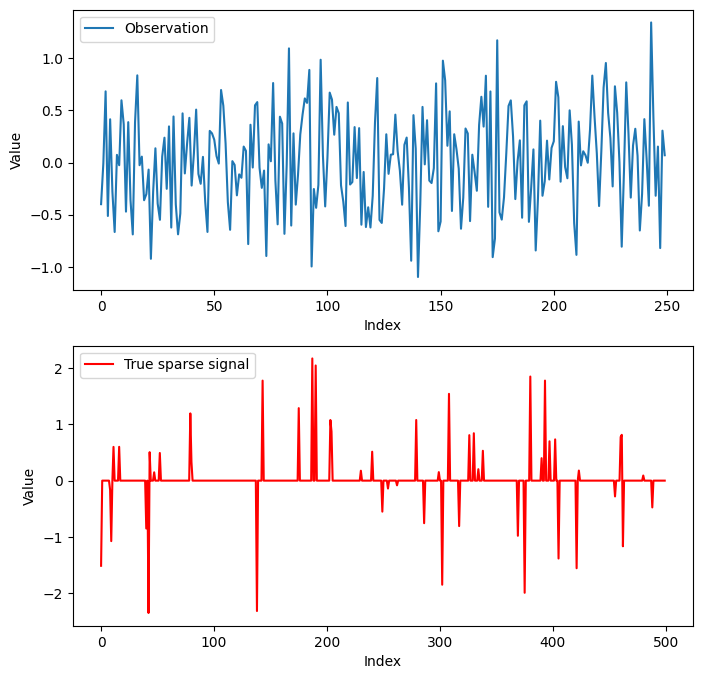

In [60]:
x_exm, s_exm =test_set.dataset.__getitem__(20)
plt.figure(figsize=(8, 8)) 
plt.subplot(2, 1, 1) 
plt.plot(x_exm, label = 'Observation' ) 
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.subplot (2, 1, 2) 
plt.plot(s_exm, label = 'True sparse signal', color='r')  
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend()
plt.show()

In [18]:
'''
class LISTA_LAYER(nn.Module):
    def __init__(self, A):
        super().__init__()

        # Initialization of the learnable parameters
        self.A = A
        self.W1 = nn.Linear(A.shape[0], A.shape[1], bias=False)
        self.W2 = nn.Linear(A.shape[1], A.shape[1], bias=False)

        self.beta = nn.Parameter(torch.ones(1, 1, 1), requires_grad=True)       
        
        self.W1.weight.data = A.t()
        self.W2.weight.data = A.t() @ A
        
    def _shrink(self, x, beta):
        return beta * F.softshrink(x / beta, lambd=1)
    
    def forward(self, y, x):       
        if x is None:
            x = torch.zeros(y.shape[0], self.A.shape[1])

        return self._shrink(self.W1(y) + self.W2(x), 
                            self.beta)
    
class LISTA_Net(nn.Module):
    def __init__(self, A, K = 5):
        super(LISTA_Net, self).__init__()

        # Number of layers <-> iterations
        self.K = K

        # Layers
        self.LISTA_layers = nn.ModuleList([LISTA_LAYER(A) for _ in range(self.K + 1)])

        # Losses when doing inference
        self.losses = []

    def forward(self, y, S = None):     

        x = self.LISTA_layers[0].forward(y,None)

        for i in range(1, self.K + 1):

            x = self.LISTA_layers[i].forward(y,x)

            if S is not None:
                self.losses.append(F.mse_loss(x.detach(), S.detach(), reduction="sum").data.item())
                
        return x
'''

### Learn-to-optimize (L2O) ISTA 

In [61]:
class L2O_ISTA(nn.Module):
    def __init__(self, A, beta_ = 0.1, K = 5):
        super(L2O_ISTA, self).__init__()

        # Number of layers <-> iterations
        self.K = K

        #Parameters
        self.W1 = nn.Linear(A.shape[0], A.shape[1], bias=False)
        self.W2 = nn.Linear(A.shape[1], A.shape[1], bias=False)

        norm = (1.001*torch.linalg.norm(A.T @ A, 2))
        self.beta = nn.Parameter(torch.ones(self.K + 1, 1, 1) * beta_ / norm, requires_grad=True)       
        self.mu = nn.Parameter(torch.ones(self.K + 1, 1, 1) / norm, requires_grad=True)    

        self.W1.weight.data = A.t()
        self.W2.weight.data = A.t() @ A

        # Losses when doing inference
        self.losses = torch.zeros(self.K)
        for param in self.W1.parameters():
            param.requires_grad = False

        for param in self.W2.parameters():
            param.requires_grad = False

    def _shrink(self, x, beta):
        return beta * F.softshrink(x / beta, lambd=1)
    
    def forward(self, y, S = None):     

        x = self._shrink(self.mu[0,:,:] * self.W1(y) , 
                            self.beta[0, : ,:])

        for i in range(1, self.K + 1):

            x = self._shrink(x - self.mu[i,:,:] * (self.W2(x) - self.W1(y)), self.beta[i, : ,:])

            if S is not None:
                    self.losses[i - 1] += F.mse_loss(x.detach(), S.detach(), reduction="sum").data.item()
                
        return x

### LISTA

In [65]:
class LISTA_Net(nn.Module):
    def __init__(self, A, beta_ = 0.1, K = 5):
        super(LISTA_Net, self).__init__()

        # Number of layers <-> iterations
        self.K = K

        #Parameters
        self.W1 = nn.Linear(A.shape[1], A.shape[0], bias=False)
        self.W2 = nn.Linear(A.shape[1], A.shape[1], bias=False)

        norm = (1.001*torch.linalg.norm(A.T @ A, 2))
        self.beta = nn.Parameter(torch.ones(self.K + 1, 1, 1) * beta_ / norm, requires_grad=True)       
        self.mu = nn.Parameter(torch.ones(self.K + 1, 1, 1) / norm, requires_grad=True)

        self.W1.weight.data = A.t() 
        self.W2.weight.data = A.t() @ A 

        # Losses when doing inference
        self.losses = torch.zeros(self.K)

    def _shrink(self, x, beta):
        return beta * F.softshrink(x / beta, lambd=1)
    
    def forward(self, y, S = None):     

        x = self._shrink(self.mu[0,:,:] * self.W1(y), self.beta[0, : ,:])

        for i in range(1, self.K + 1):

            x = self._shrink(x - self.mu[i, :, :] * (self.W2(x) - self.W1(y)), self.beta[i, : ,:])

            if S is not None:

                with torch.no_grad():

                    self.losses[i - 1] += F.mse_loss(x.detach(), S.detach(), reduction="sum").data.item()
                
        return x

In [82]:
def train(model, train_loader, valid_loader, lr=5e-3, num_epochs=100, verbose=True, clip_value=10.0, eps=1e-6):
    # Use Adam optimizer with custom epsilon for stability
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr,
        eps=eps,  # Adjust the tolerance for Adam
    )
    
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=50, gamma=0.1
    )

    loss_train = np.zeros((num_epochs,))
    loss_test = np.zeros((num_epochs,))

    # Main train loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for _, (Y, S) in enumerate(train_loader):
            S_hat = model.forward(Y)
            
            # Calculate NMSE
            mse_loss = F.mse_loss(S_hat, S, reduction="sum")
            norm_factor = torch.sum(S ** 2)
            nmse = mse_loss / norm_factor

            # Convert to dB
            nmse_db = 10 * torch.log10(nmse + eps)

            optimizer.zero_grad()
            nmse_db.backward()

            # Apply gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            optimizer.step()
            
            model.zero_grad()
            train_loss += nmse_db.data.item()

        loss_train[epoch] = train_loss / len(train_loader.dataset)
        scheduler.step()

        # Validation
        model.eval()
        test_loss = 0
        for _, (Y, S) in enumerate(valid_loader):
            S_hat = model.forward(Y)
            
            # Calculate NMSE for validation
            mse_loss = F.mse_loss(S_hat, S, reduction="sum")
            norm_factor = torch.sum(S ** 2)
            nmse = mse_loss / norm_factor

            # Convert to dB
            nmse_db = 10 * torch.log10(nmse + eps)
            test_loss += nmse_db.data.item()
            
        loss_test[epoch] = test_loss / len(valid_loader.dataset)

        # Log progress
        if epoch % 10 == 0 and verbose:
            print(
                "Epoch %d, Train NMSE (dB) %.8f, Validation NMSE (dB) %.8f"
                % (epoch, loss_train[epoch], loss_test[epoch])
            )

    return loss_test


In [83]:
model = LISTA_Net(torch.clone(A_), 0.1, 16)
loss = train(model, train_set, test_set, num_epochs=100)

Epoch 0, Train NMSE (dB) -0.01108443, Validation NMSE (dB) -0.01385720
Epoch 10, Train NMSE (dB) -0.02947917, Validation NMSE (dB) -0.01965798
Epoch 20, Train NMSE (dB) -0.03243513, Validation NMSE (dB) -0.02139409
Epoch 30, Train NMSE (dB) -0.03377486, Validation NMSE (dB) -0.02245538
Epoch 40, Train NMSE (dB) -0.03505298, Validation NMSE (dB) -0.02362506
Epoch 50, Train NMSE (dB) -0.03764521, Validation NMSE (dB) -0.02447483
Epoch 60, Train NMSE (dB) -0.05118100, Validation NMSE (dB) -0.02575245
Epoch 70, Train NMSE (dB) -0.05303352, Validation NMSE (dB) -0.02679320
Epoch 80, Train NMSE (dB) -0.05430358, Validation NMSE (dB) -0.02790141
Epoch 90, Train NMSE (dB) -0.05555552, Validation NMSE (dB) -0.02865796


In [68]:
model.mu

Parameter containing:
tensor([[[0.1782]],

        [[0.1868]],

        [[0.1889]],

        [[0.1883]],

        [[0.1866]],

        [[0.1840]],

        [[0.1815]],

        [[0.1799]],

        [[0.1799]],

        [[0.1813]],

        [[0.1844]],

        [[0.1892]],

        [[0.1965]],

        [[0.2066]],

        [[0.2207]],

        [[0.2207]],

        [[0.9772]]], requires_grad=True)

In [69]:
model.beta

Parameter containing:
tensor([[[0.1350]],

        [[0.1105]],

        [[0.0892]],

        [[0.0731]],

        [[0.0613]],

        [[0.0524]],

        [[0.0464]],

        [[0.0429]],

        [[0.0408]],

        [[0.0401]],

        [[0.0404]],

        [[0.0419]],

        [[0.0447]],

        [[0.0485]],

        [[0.0539]],

        [[0.0986]],

        [[0.1977]]], requires_grad=True)

In [ ]:
model = L2O_ISTA(torch.clone(A_), 0.4, 16)
loss = train(model, train_set, test_set)

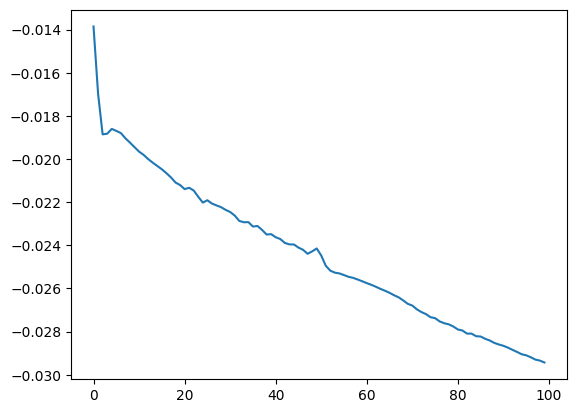

In [86]:
plt.plot(loss)


### Comparing ISTA and LISTA

In [71]:
def ISTA_torch(y, A, S, rho=0.5, L=1, max_itr=300):

    loss = np.zeros(max_itr)
    x_hat = torch.zeros(A.shape[1])
    proj = torch.nn.Softshrink(lambd= rho / L)

    for idx in range(max_itr):
        x_tilde = x_hat - 1 / L * (A.T @ (A @ x_hat - y))
        x_hat = proj(x_tilde)

        # Loss tracking
        loss[idx] = F.mse_loss(x_hat, S, reduction="sum").data.item()

    return loss

def ISTA_BATCH(test_loader, T, A, rho=1):
    A = A.cpu()
    m = A.shape[1]
    L = float(scipy.linalg.eigvalsh(A.t() @ A, eigvals=(m - 1, m - 1)))

    # Aggregate T iterations' MSE loss
    losses = np.zeros((len(test_loader.dataset), T))
    for idx, (y, S) in enumerate(test_loader.dataset):
        losses[idx, :] = ISTA_torch(y=y, A=A, S=S, L=L, max_itr=T)

    return losses.mean(axis=0)

In [72]:
def FISTA_torch(y, A, S, rho=0.5, L=1, max_itr=300):
    loss = np.zeros(max_itr)
    x_hat = torch.zeros(A.shape[1])
    x_old = x_hat.clone()  # Keep track of previous x_hat
    proj = torch.nn.Softshrink(lambd=rho / L)
    t = 1

    for idx in range(max_itr):
        # Calculate the gradient descent step
        x_tilde = x_hat - 1 / L * (A.T @ (A @ x_hat - y))
        
        # Apply soft-thresholding
        x_new = proj(x_tilde)
        
        # Update momentum parameter
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2

        # Combine the momentum step with the update
        x_hat = x_new + (t - 1) / t_new * (x_new - x_old)

        # Track the loss
        loss[idx] = F.mse_loss(x_hat, S, reduction="sum").data.item()

        # Update for the next iteration
        x_old = x_new.clone()
        t = t_new

    return loss

def FISTA_BATCH(test_loader, T, A, rho=1):
    A = A.cpu()
    m = A.shape[1]
    L = float(scipy.linalg.eigvalsh(A.t() @ A, eigvals=(m - 1, m - 1)))

    # Aggregate T iterations' MSE loss
    losses = np.zeros((len(test_loader.dataset), T))
    for idx, (y, S) in enumerate(test_loader.dataset):
        losses[idx, :] = FISTA_torch(y=y, A=A, S=S, L=L, max_itr=T)

    return losses.mean(axis=0)

In [28]:
def LISTA_INFERENCE(lista_model, test_loader):
    
    lista_model.losses = torch.zeros(lista_model.K)
    
    for _, (Y, S) in enumerate(test_loader):
        _ = lista_model.forward(Y, S)
        
    L = lista_model.losses

    lista_model.losses = torch.zeros(lista_model.K)

    return np.array(L)/len(test_loader.dataset)

In [73]:
M = 1
LAYERS = 16

ISTA_LOSS = np.zeros((M, 100))
FISTA_LOSS = np.zeros((M, 100))
LISTA_LOSS = np.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation


    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, 100, A_, rho = 0.2)
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, 100, A_, rho = 0.2)
    LISTA_LOSS[m,:] = LISTA_INFERENCE(model, test_set)

100%|██████████| 1/1 [00:17<00:00, 17.50s/it]


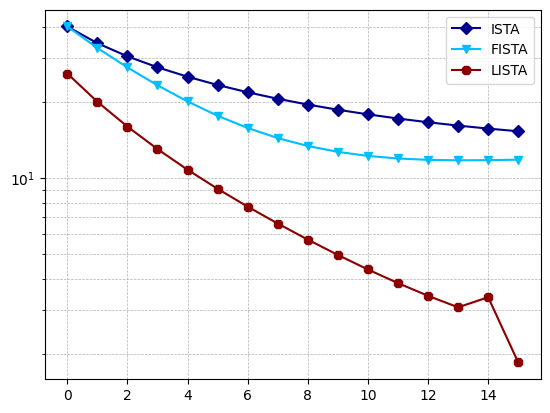

In [75]:
plt.plot(np.mean(ISTA_LOSS, axis = 0)[0:16], label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(10), 
                np.mean(ISTA_LOSS, axis = 0)[0:10] - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0)[0:10], 
                np.mean(ISTA_LOSS, axis = 0)[0:10] + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0)[0:10], 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0)[0:16], label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(10), 
                np.mean(FISTA_LOSS, axis = 0)[0:10] - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0)[0:10], 
                np.mean(FISTA_LOSS, axis = 0)[0:10] + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0)[0:10], 
                color='skyblue', 
                alpha=0.2)

plt.plot(np.mean(LISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(LISTA_LOSS, axis = 0) - (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    np.mean(LISTA_LOSS, axis = 0) + (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    color='lightcoral', 
                    alpha=0.2)

plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.yscale('log')

# ALISTA - Linear transformation is computed analitically

In [59]:
class ALISTA(nn.Module):
    def __init__(self, A, beta_ = 0.1, K=5):
        super(ALISTA, self).__init__()

        # Number of layers <-> iterations
        self.K = K

        # Parameters
        self.A = A
        self.W = self.W_optimization() 

        norm = (1.001*torch.linalg.norm(self.A.T @ self.A, 2))
        self.beta = nn.Parameter(torch.ones(self.K + 1, 1, 1) * beta_ / norm, requires_grad=True)
        self.mu = nn.Parameter(torch.ones(self.K + 1, 1, 1) / norm, requires_grad=True)

        self.W1 = self.W.T @ self.A
        self.W2 = self.W.T
        
        # Losses when doing inference
        self.losses = torch.zeros(self.K)

    def W_optimization(self):

        N, M = self.A.shape
        W = cp.Variable((N, M))

        objective = cp.Minimize(cp.norm(W.T @ self.A.cpu().numpy(), 'fro'))
        constraints = [W[:, m].T @ self.A.numpy()[:, m] == 1 for m in range(M)]
        prob = cp.Problem(objective, constraints)

        prob.solve()

        return torch.from_numpy(W.value).float()

    def _shrink(self, x, beta):
        return beta * F.softshrink(x / beta, lambd=1)

    def forward(self, y, S=None):
        
        # Initial estimation with shrinkage
        h = self.mu[0, :, :] * torch.matmul(y ,self.W2.t())
        x = self._shrink(h, self.beta[0, :, :])
        
        for i in range(1, self.K + 1):
            k = self.mu[i, :, :] * (torch.matmul(x ,self.W1.t()) - torch.matmul(y ,self.W2.t()))
            h = x - k
            x = self._shrink(h, self.beta[i, :, :])

            # If ground truth is provided, calculate the loss for monitoring

            if S is not None:

                with torch.no_grad():

                    self.losses[i - 1] += F.mse_loss(x.detach(), S.detach(), reduction="sum").data.item()
        return x

In [55]:
# Dimensions for the signal, its sparsity and its observation

n_ = 200
m_ = 150
p_ = 0.05

# Sensing matrix

A_ = torch.normal(0, torch.sqrt(torch.tensor(1/n_)), size = (m_, n_))
A_ /= torch.linalg.norm(A_, dim = 0)

# Building a training set and a test set 
train_set = SyntheticSignals(
    A = A_,
    n = n_,        
    m = m_,
    p = p_,
    SNR = 100,
    size = 800
    ).set_loader()

test_set = SyntheticSignals(
    A = A_,
    n = n_,        
    m = m_,
    p = p_,
    SNR = 100,
    size = 800
    ).set_loader()

In [60]:
model = ALISTA(torch.clone(A_), 1, 20)
loss = train(model, train_set, test_set)

Epoch 0, Train loss 3.71866539, Validation loss 0.58208467
Epoch 10, Train loss 0.64763295, Validation loss 1.15216026
Epoch 20, Train loss 0.11204776, Validation loss 0.16849619
Epoch 30, Train loss 0.09425176, Validation loss 0.10455251
Epoch 40, Train loss 0.08416795, Validation loss 0.08455077
Epoch 50, Train loss 0.08044830, Validation loss 0.08022489
Epoch 60, Train loss 0.07943143, Validation loss 0.07941208
Epoch 70, Train loss 0.07909282, Validation loss 0.07907732
Epoch 80, Train loss 0.07884323, Validation loss 0.07882456
Epoch 90, Train loss 0.07860827, Validation loss 0.07858873


# TiLISTA - Entangling LISTA linear layers

In [35]:
class TiLISTA(nn.Module):
    def __init__(self, A, beta_ = 0.1, K = 5):
        super(TiLISTA, self).__init__()

        # Number of layers <-> iterations
        self.K = K

        # Parameters
        self.A = A
        norm = (1.001*torch.linalg.norm(self.A.T @ self.A, 2))

        self.beta = nn.Parameter(torch.ones(self.K + 1, 1, 1) * beta_ / norm, requires_grad=True)
        self.mu = nn.Parameter(torch.ones(self.K + 1, 1, 1)  / norm, requires_grad=True)
        
        # Linear layers
        self.W = nn.Linear(A.shape[1], A.shape[0], bias=False)
        self.W.weight.data = self.A.T
        
        # Losses when doing inference
        self.losses = torch.zeros(self.K)

    def _shrink(self, x, beta):
        return beta * F.softshrink(x / beta, lambd=1)

    def forward(self, y, S=None):
        
        # Initial estimation with shrinkage
        h = self.mu[0, :, :] * self.W(y)
        x = self._shrink(h, self.beta[0, :, :])
        
        for i in range(1, self.K + 1):
            k = self.mu[i, :, :] * (self.W(torch.matmul(x, self.A.t()) - y))
            h = x - k
            x = self._shrink(h, self.beta[i, :, :])

            # If ground truth is provided, calculate the loss for monitoring
            if S is not None:

                with torch.no_grad():

                    self.losses[i - 1] += F.mse_loss(x.detach(), S.detach(), reduction="sum").data.item()
   
        return x

In [ ]:
model = TiLISTA(torch.clone(A_), 0.4, 20)
loss = train(model, train_set, test_set)

### LISTA vs ALISTA vs TILISTA - Fight!

### Noiseless case

In [77]:
M = 50
LAYERS = 20
BETA_INIT = 1
EPOCHS = 50
SNR = None

LISTA_LOSS = np.zeros((M, LAYERS))
ALISTA_LOSS = np.zeros((M, LAYERS))
TiLISTA_LOSS = np.zeros((M, LAYERS))
L2O_ISTA_LOSS = np.zeros((M, LAYERS))
ISTA_LOSS = np.zeros((M, LAYERS))
FISTA_LOSS = np.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 300
    m_ = 150
    p_ = 0.05

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 1200
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 300
        ).set_loader()
    
    model1 = LISTA_Net(torch.clone(A_), BETA_INIT, LAYERS)
    train(model1, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model2 = ALISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model2, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model3 = TiLISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model3, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model4 = L2O_ISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model4, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    LISTA_LOSS[m,:] = LISTA_INFERENCE(model1, test_set)
    ALISTA_LOSS[m,:] = LISTA_INFERENCE(model2, test_set)
    TiLISTA_LOSS[m,:] = LISTA_INFERENCE(model3, test_set)
    L2O_ISTA_LOSS[m,:] = LISTA_INFERENCE(model4, test_set)

    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)

# Sometimes convergence is not reached in training
LISTA_LOSS = LISTA_LOSS[~np.isnan(LISTA_LOSS).any(axis=1)]
ALISTA_LOSS = ALISTA_LOSS[~np.isnan(ALISTA_LOSS).any(axis=1)]
TiLISTA_LOSS = TiLISTA_LOSS[~np.isnan(TiLISTA_LOSS).any(axis=1)]
L2O_ISTA_LOSS = L2O_ISTA_LOSS[~np.isnan(L2O_ISTA_LOSS).any(axis=1)]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [1:18:58<00:00, 94.77s/it]


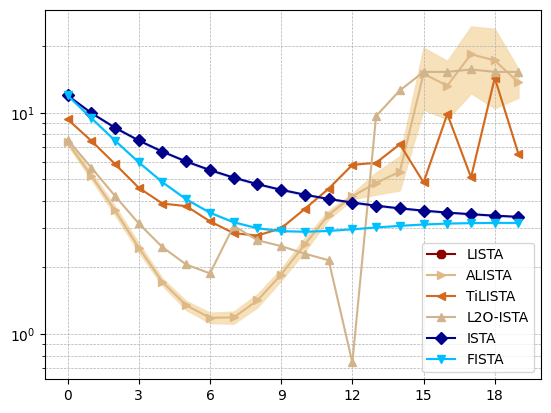

In [79]:
plt.plot(np.mean(LISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(LISTA_LOSS, axis = 0) - (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    np.mean(LISTA_LOSS, axis = 0) + (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    color='darkred', 
                    alpha=0.1)

plt.plot(np.mean(ALISTA_LOSS, axis = 0), label='ALISTA', color='burlywood', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(ALISTA_LOSS, axis = 0) - (2/np.sqrt(ALISTA_LOSS.shape[1])) * np.std(ALISTA_LOSS, axis = 0), 
                    np.mean(ALISTA_LOSS, axis = 0) + (2/np.sqrt(ALISTA_LOSS.shape[1])) * np.std(ALISTA_LOSS, axis = 0), 
                    color='wheat', 
                    alpha=0.9)

plt.plot(np.mean(TiLISTA_LOSS, axis = 0), label='TiLISTA', color='chocolate', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLISTA_LOSS, axis = 0) - (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    np.mean(TiLISTA_LOSS, axis = 0) + (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    color='sandybrown', 
                    alpha=0.2)
plt.plot(np.mean(L2O_ISTA_LOSS, axis = 0), label='L2O-ISTA', color='tan', marker = '^')
plt.fill_between(range(LAYERS), 
                    np.mean(L2O_ISTA_LOSS, axis = 0) - (2/np.sqrt(L2O_ISTA_LOSS.shape[1])) * np.std(L2O_ISTA_LOSS, axis = 0), 
                    np.mean(L2O_ISTA_LOSS, axis = 0) + (2/np.sqrt(L2O_ISTA_LOSS.shape[1])) * np.std(L2O_ISTA_LOSS, axis = 0), 
                    color='moccasin', 
                    alpha=0.2)
plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0), label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0) - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                np.mean(FISTA_LOSS, axis = 0) + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                color='skyblue', 
                alpha=0.2)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.yscale('log')

### 20db gain 

In [47]:
M = 50
LAYERS = 16
BETA_INIT = 0.4
EPOCHS = 50
SNR = 100

LISTA_LOSS = np.zeros((M, LAYERS))
ALISTA_LOSS = np.zeros((M, LAYERS))
TiLISTA_LOSS = np.zeros((M, LAYERS))
L2O_ISTA_LOSS = np.zeros((M, LAYERS))
ISTA_LOSS = np.zeros((M, LAYERS))
FISTA_LOSS = np.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 200
    m_ = 150
    p_ = 0.05

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 800
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 200
        ).set_loader()
    
    model1 = LISTA_Net(torch.clone(A_), BETA_INIT, LAYERS)
    train(model1, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model2 = ALISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model2, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model3 = TiLISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model3, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model4 = L2O_ISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model4, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    LISTA_LOSS[m,:] = LISTA_INFERENCE(model1, test_set)
    ALISTA_LOSS[m,:] = LISTA_INFERENCE(model2, test_set)
    TiLISTA_LOSS[m,:] = LISTA_INFERENCE(model3, test_set)
    L2O_ISTA_LOSS[m,:] = LISTA_INFERENCE(model4, test_set)

    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)

# Sometimes convergence is not reached in training
LISTA_LOSS = LISTA_LOSS[~np.isnan(LISTA_LOSS).any(axis=1)]
ALISTA_LOSS = ALISTA_LOSS[~np.isnan(ALISTA_LOSS).any(axis=1)]
TiLISTA_LOSS = TiLISTA_LOSS[~np.isnan(TiLISTA_LOSS).any(axis=1)]
L2O_ISTA_LOSS = L2O_ISTA_LOSS[~np.isnan(L2O_ISTA_LOSS).any(axis=1)]

100%|██████████| 50/50 [28:06<00:00, 33.73s/it]


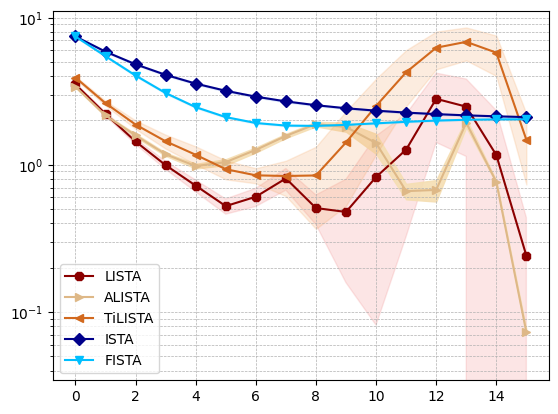

In [49]:
plt.plot(np.mean(LISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(LISTA_LOSS, axis = 0) - (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    np.mean(LISTA_LOSS, axis = 0) + (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    color='lightcoral', 
                    alpha=0.2)

plt.plot(np.mean(ALISTA_LOSS, axis = 0), label='ALISTA', color='burlywood', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(ALISTA_LOSS, axis = 0) - (2/np.sqrt(ALISTA_LOSS.shape[1])) * np.std(ALISTA_LOSS, axis = 0), 
                    np.mean(ALISTA_LOSS, axis = 0) + (2/np.sqrt(ALISTA_LOSS.shape[1])) * np.std(ALISTA_LOSS, axis = 0), 
                    color='wheat', 
                    alpha=0.9)

plt.plot(np.mean(TiLISTA_LOSS, axis = 0), label='TiLISTA', color='chocolate', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLISTA_LOSS, axis = 0) - (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    np.mean(TiLISTA_LOSS, axis = 0) + (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    color='sandybrown', 
                    alpha=0.2)

plt.plot(np.mean(L2O_ISTA_LOSS, axis = 0), label='L2O-ISTA', color='tan', marker = '^')
plt.fill_between(range(LAYERS), 
                    np.mean(L2O_ISTA_LOSS, axis = 0) - (2/np.sqrt(L2O_ISTA_LOSS.shape[1])) * np.std(L2O_ISTA_LOSS, axis = 0), 
                    np.mean(L2O_ISTA_LOSS, axis = 0) + (2/np.sqrt(L2O_ISTA_LOSS.shape[1])) * np.std(L2O_ISTA_LOSS, axis = 0), 
                    color='moccasin', 
                    alpha=0.2)

plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0), label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0) - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                np.mean(FISTA_LOSS, axis = 0) + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                color='skyblue', 
                alpha=0.2)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.legend()
plt.yscale('log')